In [1]:
library(dplyr)
library(tidyr)
library(tibble)
library(umap)
library(Rtsne)

## Plotting
library(RColorBrewer)
library(ggplot2)
library(cowplot)
library(pheatmap)

theme_set(theme_bw())


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************



In [2]:
source("R/calc.R")
source("R/misc.R")
source("R/normalise.R")
source("R/plot.R")
source("R/predict.R")
source("R/subset.R")
source("R/utils.R")

## Import data

In [12]:
# Metadata
METADATA_SID <- "data/GSE67684/processed/metadata/sid-metadata_v2.tsv"
METADATA_PID <- "data/GSE67684/processed/metadata/pid-metadata_v7.tsv"
metadata_sid <- read.table(METADATA_SID, sep = "\t")
metadata_pid <- read.table(METADATA_PID, sep = "\t", row.names = 1, quote = '"')

## Data
# Removed outliers, patients with timepoints from different batches and batch 5
SUBSET_RPATH <- "data/GSE67684/processed/subset_yeoh.tsv"
raw_yeoh <- read.table(SUBSET_RPATH, sep = "\t")

In [13]:
# Metadata
metadata_sid$label <- as.factor(metadata_sid$label)
levels(metadata_sid$label) <- c('Remission', 'Relapse')
metadata_sid$batch_info <- as.factor(metadata_sid$batch_info) 
metadata_pid$label <- as.factor(metadata_pid$label)
levels(metadata_pid$label) <- c('Remission', 'Relapse')

# SCALE->REMOVE->FILTER->LOG
scaled_yeoh <- normaliseMeanScaling(raw_yeoh)
selected_yeoh <- removeProbesets(scaled_yeoh)
yeoh <- log2_transform(filterProbesets(selected_yeoh, 0.7, metadata_sid))

# All features
yeoh_allps <- log2_transform(scaled_yeoh)
yeoh_unfltr <- log2_transform(selected_yeoh)

  P001_D0   P004_D0   P005_D0   P007_D0   P008_D0   P009_D0 
 5.796952  4.123342  3.981577  6.317643  4.841458 11.978124 
[1] "No. of ambiguous and AFFY probesets removed: 10503"
[1] D0 D0 D0 D0 D0 D0
Levels: D0 D8 N
           D0    D8     N
1053_at  TRUE  TRUE  TRUE
117_at  FALSE  TRUE  TRUE
121_at   TRUE  TRUE  TRUE
1294_at  TRUE  TRUE  TRUE
1316_at  TRUE  TRUE  TRUE
1320_at FALSE FALSE FALSE
[1] "No. of probesets removed = 6321"


#### Import DUX4, TEL-AML1-like predictions

In [8]:
# PID_DUX4 <- "tmp/pid-DUX4.txt"
# pid_dux4 <- readLines(PID_DUX4)

In [9]:
# sid_dux4 <- paste0(rep(pid_dux4, each = 2), c("_D0", "_D8"))
# metadata_sid1 <- metadata_sid
# levels(metadata_sid1$subtype) <- c(levels(metadata_sid1$subtype), "DUX4")
# metadata_sid1[sid_dux4, "subtype"] <- "DUX4"

#### Day 33

In [58]:
path1 <- "data/leuk_D33/processed/mas5_filtered.tsv"
path2 <- "data/GSE67684/processed/metadata/sid-metadata_v1.tsv"

yeoh_d33 <- read.table(path1, sep = "\t", header = T)
annot_all <- read.table(path2, sep = "\t", header = T)

annot_all[] <- lapply(annot_all, as.factor)
yeoh_d33_allps <- log2_transform(normaliseMeanScaling(yeoh_d33))
# Remove samples that have been curated out of data set
# Members that have been curated out are no longer in annot_all
missing_samples <- colnames(yeoh_d33_allps)[
  !(colnames(yeoh_d33_allps) %in% rownames(annot_all))]
# Remove patients from D33 that have been curated out
yeoh_d33 <- yeoh_d33_allps[, !(colnames(yeoh_d33_allps) %in% missing_samples)]

P001_D33 P006_D33 P007_D33 P008_D33 P009_D33 P010_D33 
2.106859 2.132480 1.498776 2.559182 1.576584 2.657973 


### Commonly used globals

In [14]:
### GLOBAL VARIABLES
metadata <- metadata_sid[colnames(yeoh),]
heatmap_metadata <- metadata[, c("batch_info", "label"), drop = F]
COL_LABEL <- c("darkolivegreen3", "tomato3")
names(COL_LABEL) <- c('Remission', 'Relapse')

# List subtypes
subtypes9 <- levels(metadata_sid$subtype)
subtypes7 <- setdiff(subtypes9, c("Hypodiploid", "Normal"))
subtypes6 <- setdiff(subtypes7, "Others")
subtypes5 <- setdiff(
  subtypes9,
  c("Hypodiploid", "Normal", "Hyperdiploid", "Others")
)
others <- yeoh[, metadata$subtype == "Others"]
others_normal <- yeoh[, metadata$subtype %in% c("Others", "Normal")]

# Define train/test split
sid_mrd_na <- rownames(metadata_pid)[is.na(metadata_pid$d33_mrd)] %>%
  rep(each = 2) %>%
  paste0(c("_D0", "_D8"))

sid_alltrain_local <- rownames(metadata)[
  !(metadata$subtype %in% c("Hypodiploid", "Normal")) &
  !(rownames(metadata) %in% sid_mrd_na)
]
sid_alltrain <- rownames(metadata)[
  !(metadata$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others", "Normal")) &
  !(rownames(metadata) %in% sid_mrd_na)
]
sid_train <- rownames(metadata)[
  metadata$batch_info %in% 1:7 &
  !(metadata$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others", "Normal")) &
  !(rownames(metadata) %in% sid_mrd_na)
]
sid_test <- rownames(metadata)[
  metadata$batch_info %in% 8:10 &
  !(metadata$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others", "Normal")) &
  !(rownames(metadata) %in% sid_mrd_na)
]

sid_remission <- rownames(metadata)[metadata$label == 0]
sid_normal <- paste0("N0", c(1,2,4))

### Identify batch effect probesets

In [15]:
batch_ps <- identify_batch_features(yeoh, metadata, method = 'aov')
length(batch_ps)

[1] "No. of NaNs = 0"


[1] 2565

In [596]:
batch_allps <- identify_batch_features(yeoh_allps, metadata, method = 'aov')
length(batch_allps)

[1] "No. of NaNs = 0"


[1] 7504

In [597]:
batch_genes <- identify_batch_features(yeoh_allgenes, metadata, method = 'aov')
length(batch_genes)

[1] "No. of NaNs = 0"


[1] 4468

## B-ALL "Others" subtypes
- DUX4
    - Overexpression of DUX4
    - Characterised by recurrent IGH-DUX4 or ERG-DUX4 fusions
    - Frequently co-occurring with intragenic ERG deletions
- ETV6-RUNX1-like
    - ETV6 and IKZF1 alterations
    - IKZF1 alterations did not result in poor prognosis, unlike other cases in B-ALL
- BCR-ABL1-like
    - No CRLF2 rearrangement
- PAX5alt
    - PAX5 as a driver mutation
    - Commonly have co-deletion of IKZF1 and CDKN2A/B
    - If IKZF1 is deleted, poor outcome. Otherwise, excellent prognosis
- ZNF384-like (uncommon)

## Feature selection

#### Plot: UMAP

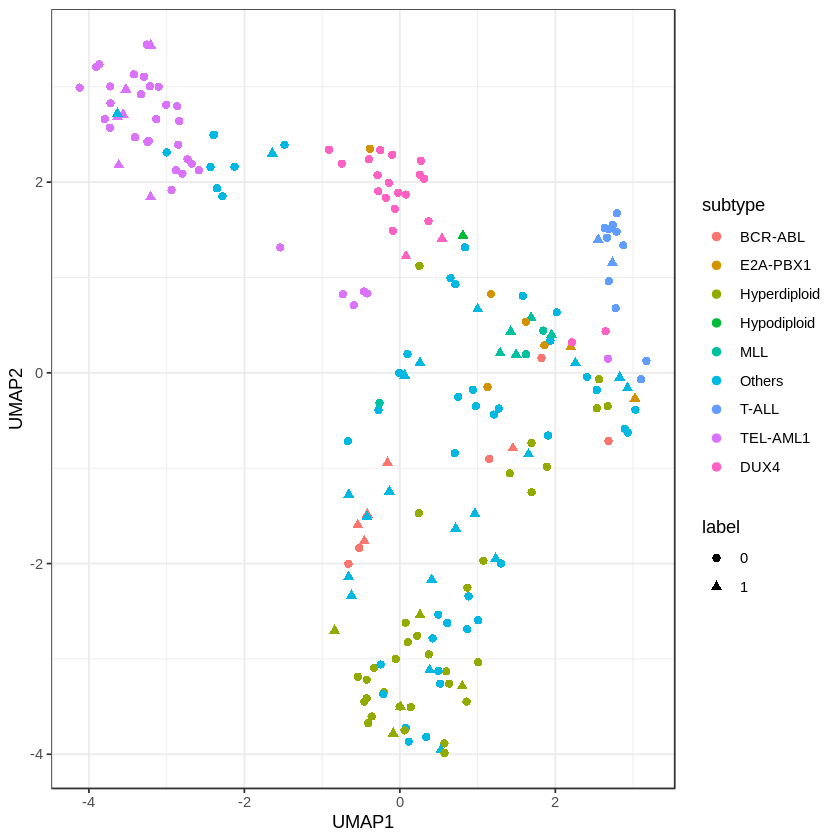

In [125]:
set.seed(0)
umap_d0_hvg500 <- ggplot_umap(
  t(D0_hvg500), metadata_sid1,
  col = "subtype", pch = "label"
)
umap_d0_hvg500

ggsave("~/Dropbox/tmp/umap-d0_hvg500_nobatch.pdf", umap_d0_hvg500, width = 7, height = 4)

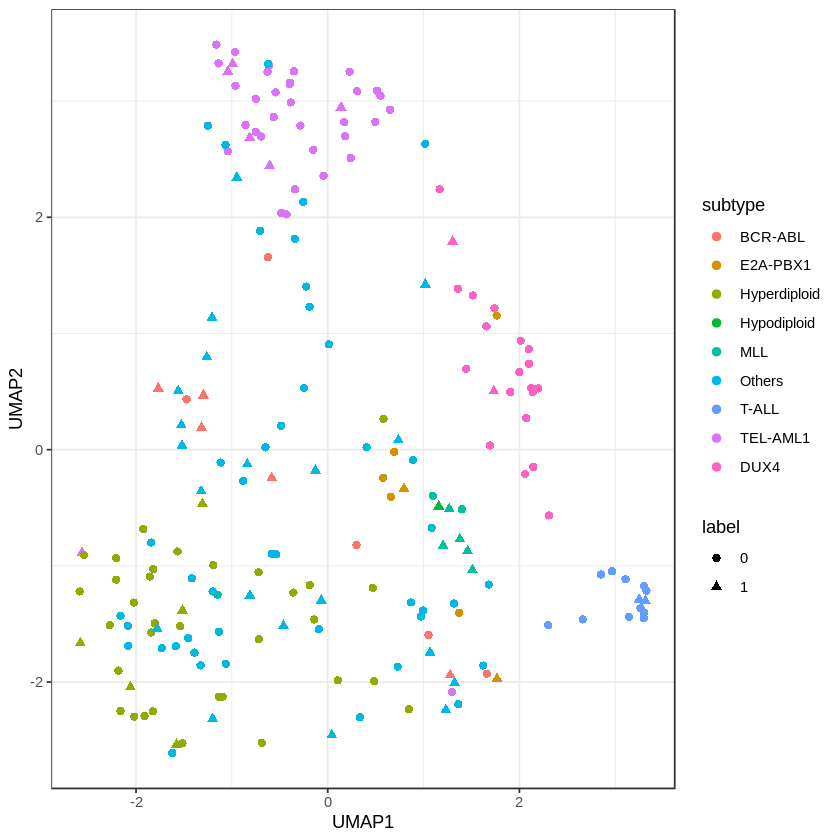

In [148]:
set.seed(0)
ax <- ggplot_umap(
  t(D0_he500), metadata_sid1,
  col = "subtype", pch = "label"
)
ax

ggsave("~/Dropbox/tmp/umap-d0_he500_nobatch.pdf", ax, width = 7, height = 4)

#### Plot: t-SNE

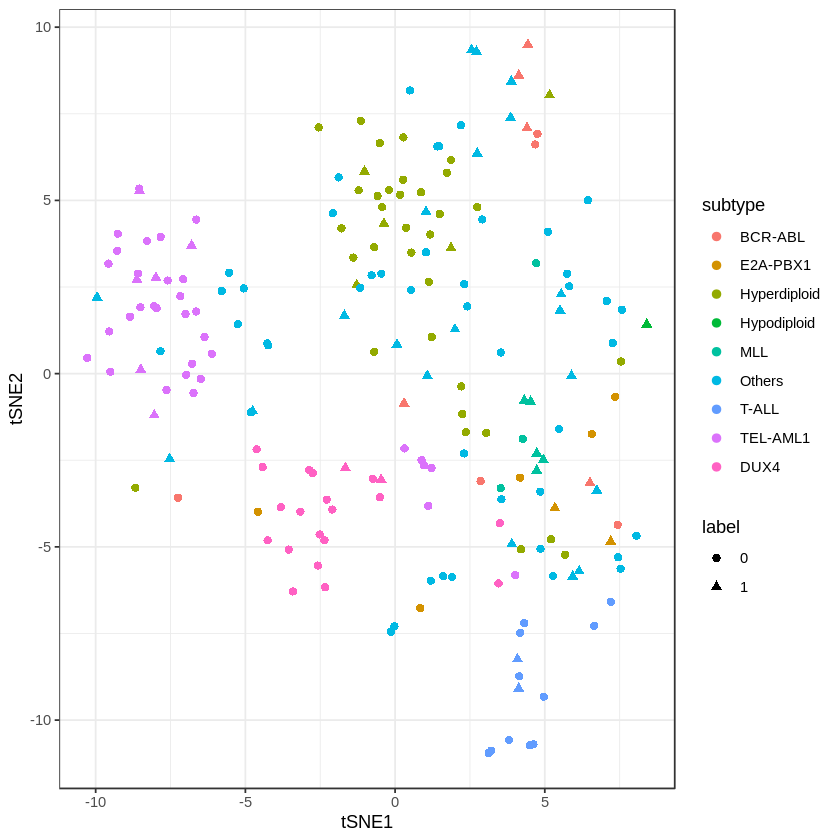

In [122]:
set.seed(0)
tsne_d0_hvg500 <- ggplot_tsne(
  t(D0_hvg500), metadata_sid1,
  col = "subtype", pch = "label"
)
tsne_d0_hvg500

ggsave("~/Dropbox/tmp/tsne-d0_hvg500_nobatch.pdf", tsne_d0_hvg500, width = 7, height = 4)

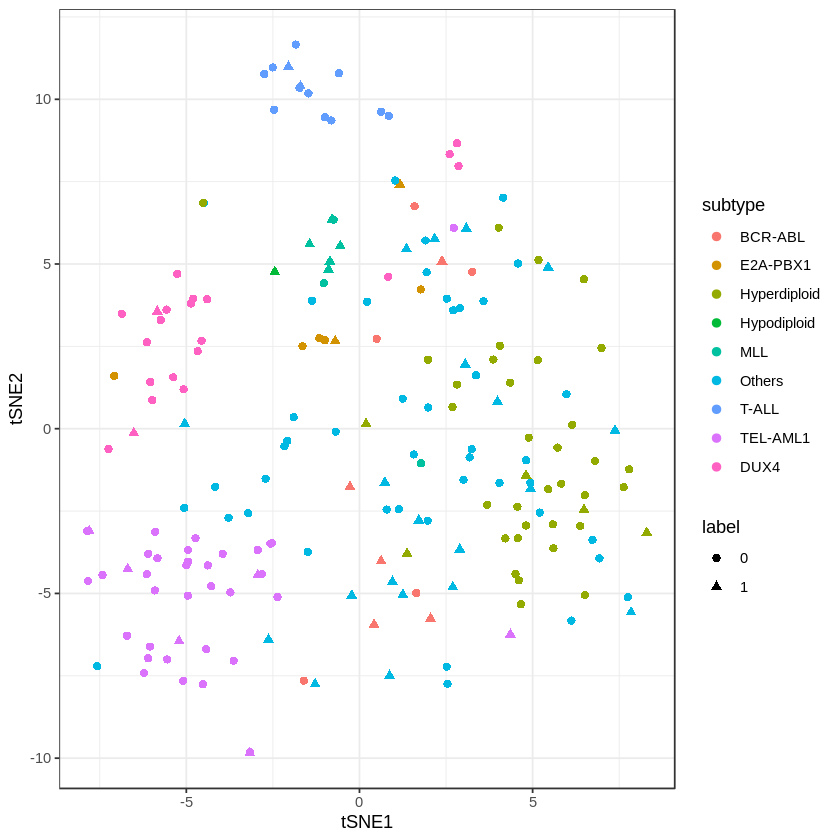

In [149]:
set.seed(0)
ax <- ggplot_tsne(
  t(D0_he500), metadata_sid1,
  col = "subtype", pch = "label"
)
ax

ggsave("~/Dropbox/tmp/tsne-d0_he500_nobatch.pdf", ax, width = 7, height = 4)

#### TODO

- Focus on identifying:
    - BCR-ABL1-like
    - Hyperdiploid

- Exploring distance methods (inspiration from UMAP, t-SNE)

# Identify novel subtypes in B-Others

#### Original figures:
- Batch effect ps: data
- Annotated data: yeoh_unfltr
- Gene mapping: yeoh_unfltr

## Yeoh (2002): Subtype gene signatures

Gene signatures selected by chi2 feature selection in Yeoh (2002).

### Combining probeset information from all subtypes (chi2 genes)

In [235]:
# path <- "data/yeoh_2002/README/chi_square_probesets"
# filenames <- list.files(path, pattern = "*.txt", full.names = TRUE)
# # Order of files in directory
# subtype_files <- c("BCR-ABL", "E2A-PBX1", "Hyperdiploid", "MLL", "DUX4", "T-ALL", "TEL-AML1")

# probeset_infos <- lapply(
#   filenames, read.table,
#   header = FALSE, sep = "\t", quote = "",
#   na.strings = " ", stringsAsFactors = F, row.names = 1
# )
# probeset_infos1 <- lapply(
#   seq_along(probeset_infos),
#   function(i) cbind(probeset_infos[[i]], subtype = subtype_files[i])
# )
# probeset_info <- do.call(rbind, probeset_infos1)
# colnames(probeset_info) <- c(
#   "affymetrix", "gene_name", "gene_symbol", "ref_num",
#   "chi2_value", "above_below_mean", "subtype"
# )
# filename <- "data/yeoh_2002/README/chi_square_probesets/processed/all_subtypes.tsv"
# write.table(probeset_info, filename, quote = FALSE, sep = "\t", row.names = FALSE)

### Loading probeset information from all subtypes (chi2 genes)

In [ ]:
filename1 <- "data/yeoh_2002/README/chi_square_probesets/processed/all_subtypes.tsv"
filename2 <- "../info/microarray/HG-U95Av2/HG_U95Av2-GEO_annot.tsv"

# Probesets belong to Affymetrix U95Av2 which is not compatible with
# newer Affymetrix microarrys.
probeset_info <- read.table(
  filename1, sep = "\t", header = T,
  quote = "", na.strings = " ", stringsAsFactors = F
)
# Affy95 probeset annotations
u95av2_annot <- read.table(
  filename2, sep = "\t", header = T,
  row.names = 1, stringsAsFactors = F
)

### Annotate U133Plus2 microarray with gene symbols

In [599]:
NAME_GPL570 <- "../info/microarray/HG-U133_Plus_2/annot_genesymbol-GPL570.tsv"
yeoh_allgenes <- affy2id(yeoh_allps, NAME_GPL570, return_annot = TRUE)
yeoh_allgenes <- obj$X
gene_mapping <- obj$mapping

No. of probesets with no ID removed = 1052
Total no. of probesets removed (incl. probesets mapping to same gene): 8762


ERROR: Error in eval(expr, envir, enclos): object 'obj' not found


In [486]:
# Gene signatures from Yeoh (2002)
chi2_ps <- probeset_info$affymetrix # [grepl("[gis]_at", ps_info$affymetrix)]
chi2_genes <- u95av2_annot[chi2_ps, "Gene.Symbol"]
chi2_genes <- unique(chi2_genes)

In [487]:
# Get all GPL570 probesets without batch effect probesets
batch_genes <- gene_mapping[batch_allps]
batch_genes <- batch_genes[!(is.na(batch_genes))]
nonbatch_genes <- setdiff(rownames(a_allps), batch_genes)

In [488]:
u133p2_genes <- rownames(a_allps)

matched_genes <- get_similar_genes(chisq_genes, u133p2_genes)
matched_genes <- Filter(function(x) !is.null(x), matched_genes)
identical_genes <- matched_genes[names(matched_genes) == matched_genes]
similar_genes <- matched_genes[!(names(matched_genes) == matched_genes)]

In [489]:
chi2_genes_u133p2 <- unlist(c(
  identical_genes,
  do.call(c, similar_genes) # vetted genes in similar genes
))

#### Get BCR-ABL1 genes from file

In [426]:
bcrabl_ps <- probeset_info %>%
  subset(subtype == "BCR-ABL", select = affymetrix, drop = TRUE)
print(length(bcrabl_ps))
chi2_genes <- unique(u95av2_annot[bcrabl_ps, "Gene.Symbol"])

matched_genes <- get_similar_genes(chi2_genes, u133p2_genes)
matched_genes <- Filter(function(x) !is.null(x), matched_genes)
identical_genes <- matched_genes[names(matched_genes) == matched_genes]
similar_genes <- matched_genes[!(names(matched_genes) == matched_genes)]
print(length(similar_genes))
bcrabl_genes_u133p2 <- unlist(identical_genes)

[1] 40
[1] 0


#### Get TEL-AML genes from file

In [310]:
telaml1_ps <- probeset_info %>%
  subset(subtype == "TEL-AML1", select = affymetrix, drop = TRUE)
print(length(telaml1_ps))
chi2_genes <- unique(u95av2_annot[telaml1_ps, "Gene.Symbol"])

matched_genes <- get_similar_genes(chi2_genes, u133p2_genes)
matched_genes <- Filter(function(x) !is.null(x), matched_genes)
identical_genes <- matched_genes[names(matched_genes) == matched_genes]
similar_genes <- matched_genes[!(names(matched_genes) == matched_genes)]
telaml1_genes_u133p2 <- unlist(identical_genes)

[1] 40


## D0 data

In [452]:
D0_genes <- yeoh_allgenes[, metadata[colnames(yeoh_allgenes), "class_info"] == "D0"]
D0_genes_fltr <- D0_genes[!(rownames(yeoh_allgenes) %in% batch_genes), ]

hvg500 <- select_hvg(D0_genes_fltr, 500, return.features = TRUE)
heg500 <- select_highexpr(D0_genes_fltr, 500, return.features = TRUE)

In [453]:
D0 <- yeoh[, metadata[colnames(yeoh), "class_info"] == "D0"]
D0_fltr <- D0[!(rownames(yeoh) %in% batch_ps), ]

hvps500 <- select_hvg(D0_fltr, 500, return.features = TRUE)
heps500 <- select_highexpr(D0_fltr, 500, return.features = TRUE)

# DUX4

In [26]:
# All D0 samples
ayeoh_fltr <- a_allps[
  gene_signatures,
  annot[colnames(a_allps), "class_info"] == "D0"
]
# ayeoh_fltr <- ayeoh_fltr[rowSums(ayeoh_fltr) != 0, ]

# Select top 50 HVG from signatures
ayeoh_fltr1 <- select_hvg(ayeoh_fltr, 50)

In [28]:
# Heatmap settings
heatmap_annot <- annot[, "subtype", drop = F]
colnames(heatmap_annot) <- "Subtype"

# set1_colours <- ggplot_palette(9)
set1_colours <- brewer.pal(n = 9, name = "Set1")
names(set1_colours) <- rev(levels(heatmap_annot$Subtype))
annot_colours <- list(Subtype = set1_colours) 

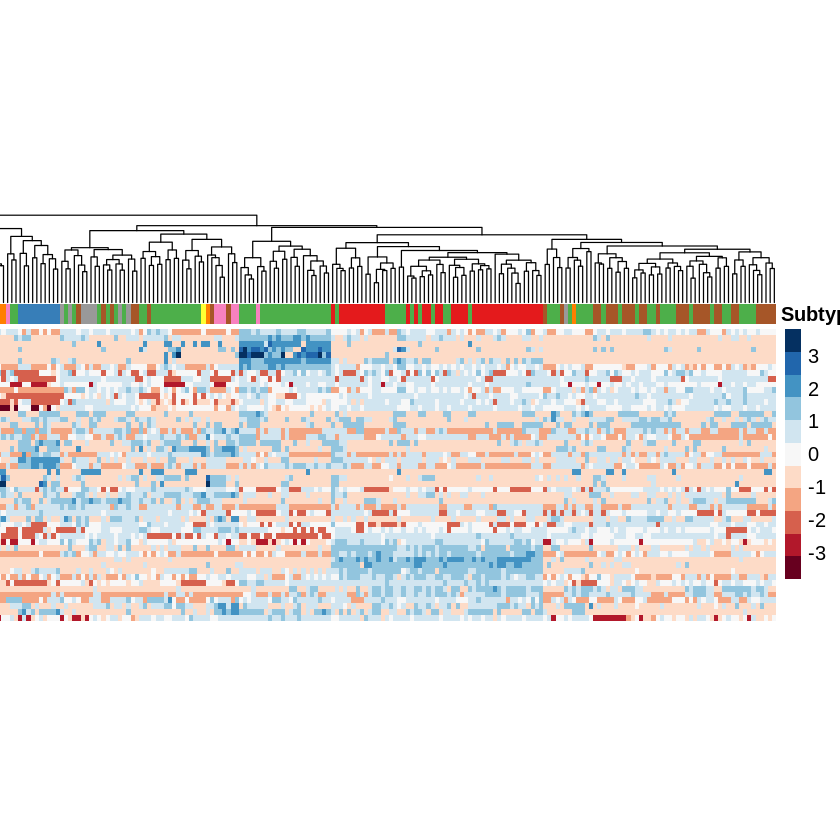

In [29]:
yeoh2002_hclust <- pheatmap(
  ayeoh_fltr1,
  col = brewer.pal(n = 11, name = "RdBu"),
  display_numbers = F, legend = T, border_color = NULL,
  cluster_method = "complete", cluster_rows = T, cluster_cols = T,
  clustering_distance_rows = "euclidean", clustering_distance_cols = "euclidean",
  scale = "row", show_colnames = F, show_rownames = F,
  annotation = heatmap_annot, annotation_colors = annot_colours,
  fontsize = 12, cellwidth = 2.5, cellheight = 3.5
#   filename = "~/Dropbox/tmp/heatmap-yeoh_signature.pdf"
)

In [26]:
# pid <- get_colnames(yeoh2002_hclust)
# pid_subtype <- annot[pid, 'subtype']
# names(pid_subtype) <- pid
# which(names(pid_subtype) == 'P092_D0')
# which(names(pid_subtype) == 'P203_D0')
# pid_subtype[73:94]

#### Confirm DUX4 genes

In [869]:
# top50_hvg_sig <- get_rownames(all_signatures1)
# dux4_genes <- top50_hvg_sig[26:32]
# chisq_genes1 <- u95av2_annot[chisq_ps, "Gene.Symbol", drop = F]

In [874]:
# dux4_ps <- rownames(chisq_genes1)[chisq_genes1$Gene.Symbol %in% dux4_genes]
# print(dux4_ps)

[1] "31892_at" "994_at"   "995_g_at" "37542_at" "36029_at" "41708_at" "1664_at" 
[8] "1731_at"  "33037_at"


In [886]:
# rpath <- "data/yeoh_2002/README/chi_square_probesets/novel.txt"
# novel_ps <- read.table(
#   rpath, sep = "\t", row.names = 2,
#   stringsAsFactors = F, quote = "",
# )

#### Plot: UMAP

In [44]:
set.seed(0)
umap_obj <- umap(t(ayeoh_fltr1))
umap_ayeoh_fltr <- ggplot_umap(
  umap_obj, annot,
  cex = 1.5, alpha = .7, color = 'subtype'
) +
  labs(col = "subtype")

wpath <- "~/Dropbox/temp/umap-yeoh_signature.pdf"
# ggsave(wpath, umap_ayeoh_fltr, width = 6, height = 3)

#### Identify DUX4 patients

In [48]:
# DUX4 cluster (w/ E2A-PBX1)
z_umap <- umap_obj$layout
others_cluster <- z_umap[z_umap[, 2] > 4, ]

subtype_others_cluster <- annot[rownames(others_cluster), , drop = F]
dux4_subtype <- subtype_others_cluster[
  subtype_others_cluster$subtype == "Others", , drop = F]
sid_dux4_cluster <- rownames(dux4_subtype)
print(sid_dux4_cluster)

 [1] "P060_D0" "P063_D0" "P071_D0" "P073_D0" "P076_D0" "P077_D0" "P083_D0"
 [8] "P087_D0" "P090_D0" "P092_D0" "P105_D0" "P108_D0" "P111_D0" "P123_D0"
[15] "P143_D0" "P173_D0" "P174_D0" "P177_D0" "P201_D0" "P203_D0" "P212_D0"
[22] "P215_D0"


In [51]:
# Colnames from hclust
hclust_colnames <- get_colnames(yeoh2002_hclust)
sid_hclust <- hclust_colnames[73:94]
sid_dux4_hclust <- sid_hclust[annot[sid_hclust, "subtype"] == 'Others']
sid_dux4_hclust

[1] "P092_D0" "P108_D0" "P060_D0" "P212_D0" "P105_D0" "P215_D0" "P173_D0"
 [8] "P143_D0" "P174_D0" "P071_D0" "P201_D0" "P083_D0" "P076_D0" "P087_D0"
[15] "P063_D0" "P111_D0" "P073_D0" "P077_D0" "P090_D0" "P177_D0" "P203_D0"

In [52]:
print(length(sid_dux4_cluster))
print(length(sid_dux4_hclust))

sid_dux4_d0 <- intersect(sid_dux4_cluster, sid_dux4_hclust)
sid_dux4_d8 <- paste0(substring(sid_dux4_d0, 1, 4), "_D8")
sid_dux4 <- c(sid_dux4_d0, sid_dux4_d8)
print(sid_dux4_d0)

[1] 22
[1] 21
 [1] "P060_D0" "P063_D0" "P071_D0" "P073_D0" "P076_D0" "P077_D0" "P083_D0"
 [8] "P087_D0" "P090_D0" "P092_D0" "P105_D0" "P108_D0" "P111_D0" "P143_D0"
[15] "P173_D0" "P174_D0" "P177_D0" "P201_D0" "P203_D0" "P212_D0" "P215_D0"


## Identify TEL-AML1-like patients
- Using TEL-AML1 genes (chi2)
- Identified 12 B-Others patients that are TEL-AML1-like
- P095,	P126, P130,	P150, P171, P187, P191, P197, P199, P210, P213, P216

,rowname,UMAP1,UMAP2,subtype,label
,<chr>,<dbl>,<dbl>,<fct>,<fct>
P001_D0,P001,-0.55634048,2.432736,T-ALL,0
P004_D0,P004,-0.07288872,2.946666,T-ALL,0
P005_D0,P005,-0.12007392,3.286494,T-ALL,0
P007_D0,P007,-0.59198651,2.264688,T-ALL,1
P008_D0,P008,-0.44313681,3.464546,T-ALL,0
P009_D0,P009,-0.27072015,2.690046,T-ALL,0


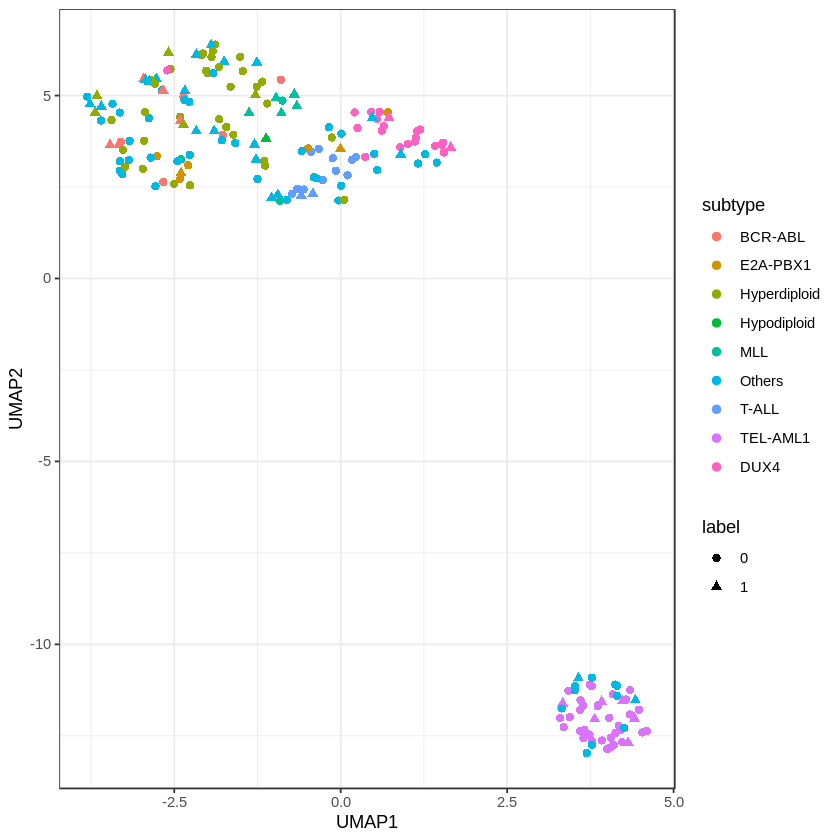

In [662]:
set.seed(1)
obj <- ggplot_umap(
  D0_genes[telaml1_genes_u133p2, ], metadata_sid1,
  col = "subtype", pch = "label",
  return_data = TRUE
)
obj$plot
# ggsave("~/Dropbox/tmp/umap-telaml1.pdf", ax, width = 6, height = 4)

In [667]:
Z <- obj$X
Z_sub <- subset(Z, UMAP2 < -10 & subtype == "Others", select = "rowname")
Z_sub

,rowname
,<chr>
P095_D0,P095
P126_D0,P126
P130_D0,P130
P150_D0,P150
P171_D0,P171
P187_D0,P187
P191_D0,P191
P197_D0,P197
P199_D0,P199


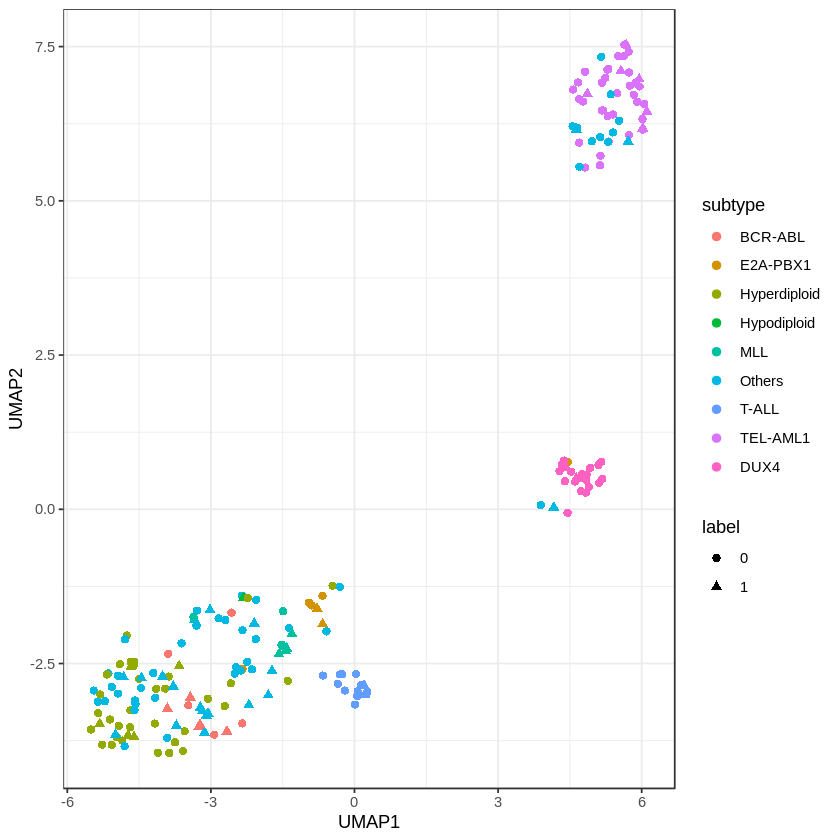

In [668]:
set.seed(1)
obj <- ggplot_umap(
  D0_genes[chi2_genes_u133p2, ], metadata_sid1,
  col = "subtype", pch = "label",
  return_data = TRUE
)
obj$plot
# ggsave("~/Dropbox/tmp/umap-telaml1.pdf", ax, width = 6, height = 4)

In [669]:
Z <- obj$X
Z_sub <- subset(Z, UMAP2 > 5 & subtype == "Others", select = "rowname")
Z_sub

,rowname
,<chr>
P095_D0,P095
P126_D0,P126
P130_D0,P130
P150_D0,P150
P171_D0,P171
P187_D0,P187
P191_D0,P191
P197_D0,P197
P199_D0,P199


#### Are there TEL-AML1-like samples that are misclassfied as TEL-AML1?

- No clear distinction between TEL-AML1 and TEL-AML1-like samples

In [551]:
set.seed(1)
Z <- ggplot_umap(
  D0_genes[telaml1_genes_u133p2, ], metadata_sid1,
  col = "subtype", pch = "label", return.data = TRUE
)
sid_telaml1_grp <- rownames(subset(Z,
  subtype == "Others" & UMAP2 < 0 | subtype == "TEL-AML1"
))

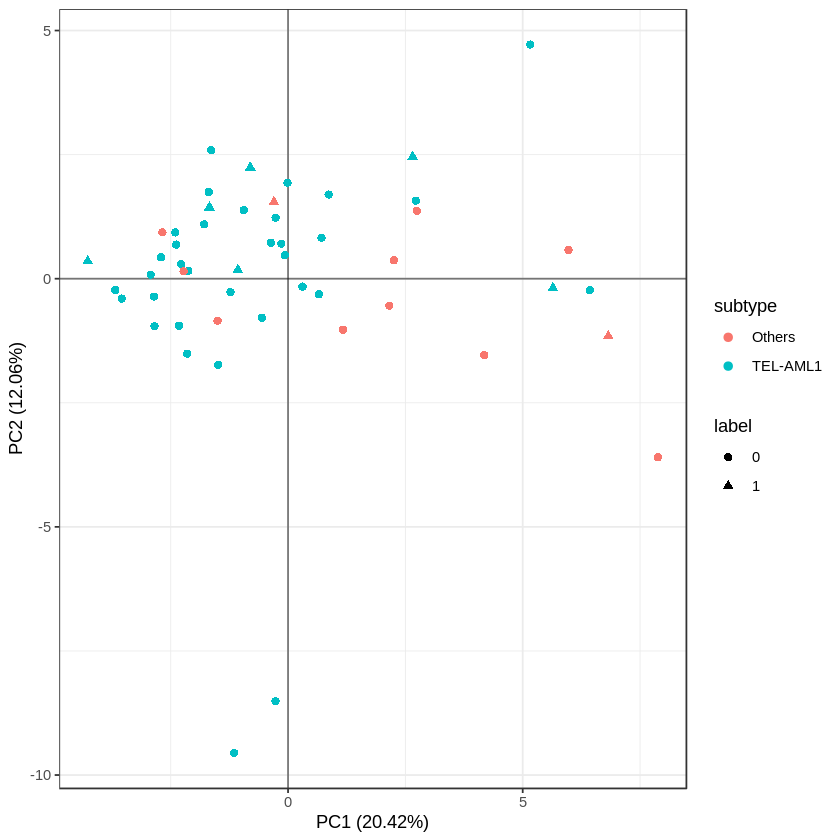

In [616]:
set.seed(1)
ax <- ggplot_pca(
  D0_genes[telaml1_genes_u133p2, sid_telaml1_grp], metadata_sid1,
  col = "subtype", pch = "label"
)
ax
# ggsave("~/Dropbox/tmp/pca_telaml1-telaml1.pdf", ax, width = 6, height = 4)

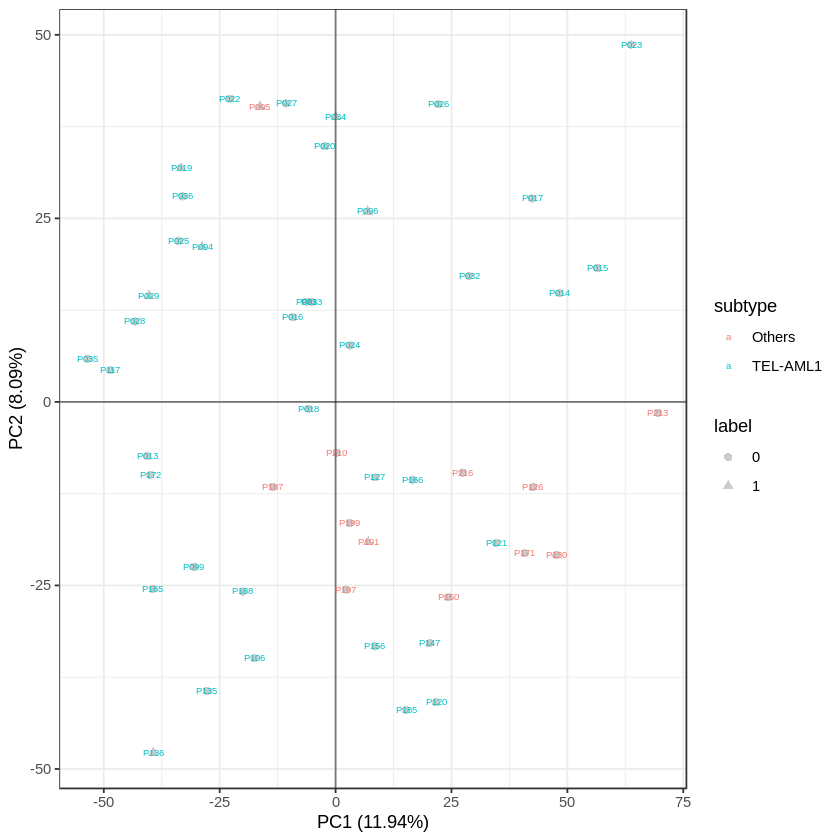

In [614]:
telaml1_hvg500 <- select_hvg(D0_genes[, sid_telaml1_grp], n = 500)

set.seed(1)
ax <- ggplot_pca(
  telaml1_hvg500, metadata_sid1,
  label = TRUE, alpha = .2,
  col = "subtype", pch = "label"
)
ax
# ggsave("~/Dropbox/tmp/pca_telaml1-hvg500_1.pdf", ax, width = 6, height = 4)

## BCR-ABL-like patients

- Using the PCA plots of the Yeoh (2002) genes and t-test probesets
- Identified 7 B-Others patients that are near BCR-ABL in both plots
- P062, P075, P097, P101, P179, P200, P202

#### BCR-ABL1 genes (chi2 genes)

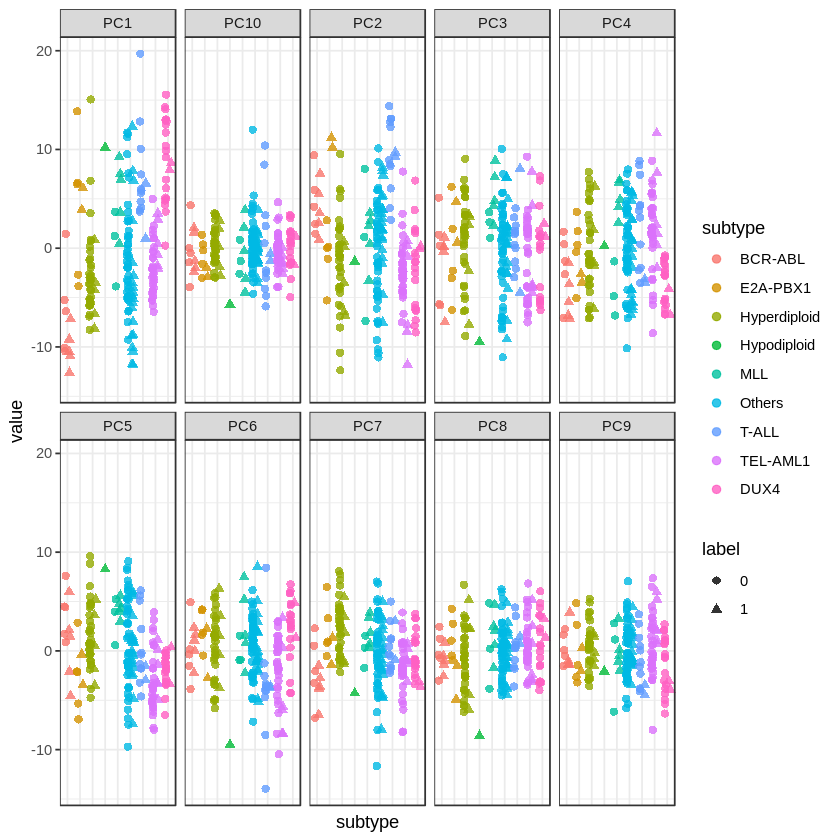

In [617]:
set.seed(1)
ax <- ggplot_top_pc(
  D0_genes[bcrabl_genes_u133p2, ],
  metadata_sid1, n = 10, col = "subtype", pch = "label"
)
ax
# ggsave("~/Dropbox/tmp/top_pc-bcrabl1.pdf", ax, width = 9, height = 5)

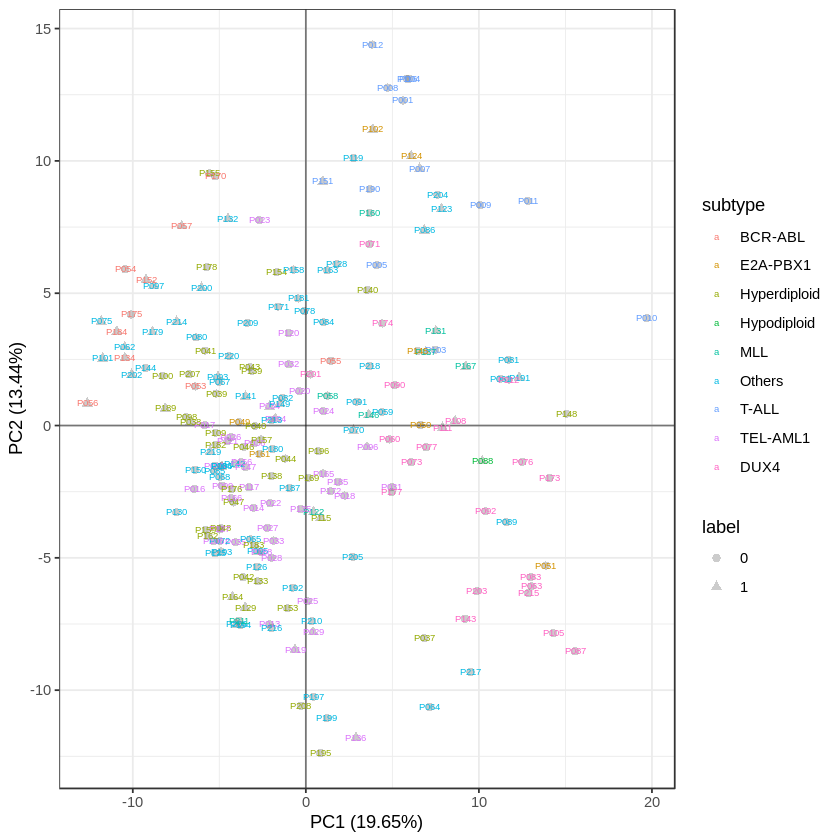

In [630]:
set.seed(1)
ax <- ggplot_pca(
  D0_genes[bcrabl_genes_u133p2, ], metadata_sid1,
  cex = 2,
  label = TRUE,
  x = "PC1", y = "PC2",
  col = "subtype", pch = "label"
)
ax
# ggsave("~/Dropbox/tmp/pca-bcrabl1a.pdf", ax, width = 7, height = 4)

#### T-test

In [472]:
# Feature selection: BCR-ABL only
idx_subtype <- metadata_sid1[colnames(D0_fltr), "subtype"] == "BCR-ABL"
d0_subtype <- D0_fltr[, idx_subtype]
d0_rest <- D0_fltr[, !idx_subtype]
row_pvalue <- calc_univariate(t.test, d0_subtype, d0_rest)
names(row_pvalue) <- substring(names(row_pvalue), 2)

# Select highly expressed probesets in BCR-ABL
EXPR <- 6
mu_bcrabl <- rowMeans(d0_subtype)
ps_high <- names(mu_bcrabl)[mu_bcrabl > EXPR]

ALPHA <- .05
ps_ttest <- names(row_pvalue)[row_pvalue < ALPHA]
ps_ttest_heg <- intersect(ps_high, ps_ttest)

length(ps_high)
length(ps_bcrabl)
length(ps_ttest_heg)

[1] 2139

[1] 490

[1] 429

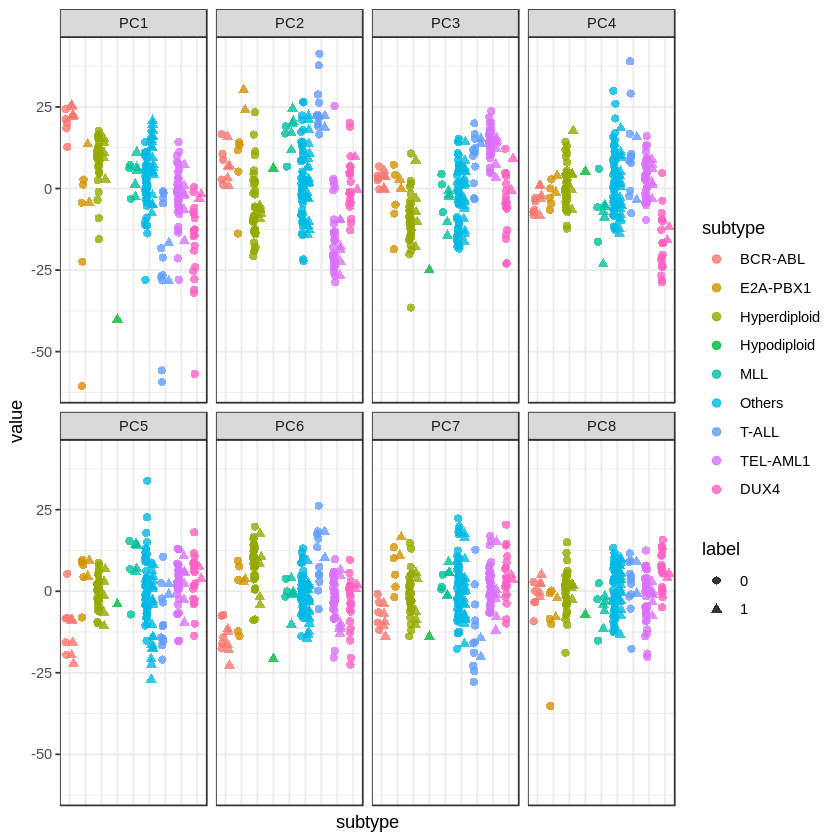

In [475]:
set.seed(1)
ax <- ggplot_top_pc(
  D0[ps_bcrabl, ],
  metadata_sid1, n = 8, col = "subtype", pch = "label"
)
ax
ggsave("~/Dropbox/tmp/top_pc-ttest.pdf", ax, width = 9, height = 5)

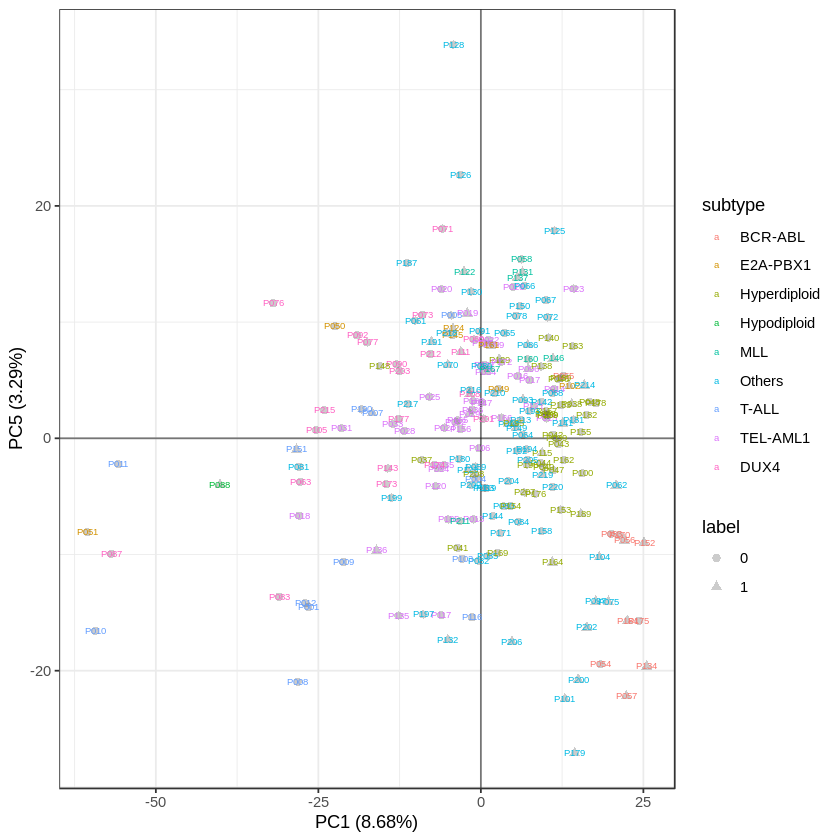

In [631]:
set.seed(1)
ax <- ggplot_pca(
  D0[ps_bcrabl, ],
  metadata_sid1,
  label = TRUE,
  x = "PC1", y = "PC5",
  col = "subtype", pch = "label"
)
ax
ggsave("~/Dropbox/tmp/pca-ttest1.pdf", ax, width = 7, height = 4)

#### BCR-ABL genes & HVG500

In [469]:
set.seed(1)
ax <- ggplot_top_pc(
  D0_genes[c(bcrabl_genes_u133p2, hvg500), ],
  metadata_sid1, n = 10, col = "subtype", pch = "label"
)
# ggsave("~/Dropbox/tmp/top_pc-bcrabl_hvg500.pdf", ax, width = 9, height = 5)

In [481]:
set.seed(1)
ax <- ggplot_pca(
  D0_genes[c(bcrabl_genes_u133p2, hvg500), ],
  metadata_sid1,
  x = "PC8", y = "PC9",
  col = "subtype", pch = "label"
)
# ggsave("~/Dropbox/tmp/pca-bcrabl_hvg500.pdf", ax, width = 7, height = 4)

## Predict: TEL-AML-like and BCR-ABL-like

In [677]:
X_normal <- yeoh[, sid_normal]
list_X_subtypes7 <- lapply(subtypes7, function(subtype) {
  yeoh[, sid_alltrain_local[metadata_sid[sid_alltrain_local, "subtype"] == subtype]]
})
names(list_X_subtypes7) <- subtypes7

In [687]:
sid_telaml1 <- sid_alltrain_local[metadata_sid[sid_alltrain_local, "subtype"] == "TEL-AML1"]
sid_bcrabl <- sid_alltrain_local[metadata_sid[sid_alltrain_local, "subtype"] == "BCR-ABL"]

In [688]:
pid_telaml1_like <- c(
  'P095', 'P126', 'P130', 'P150', 'P171', 'P187',
  'P191', 'P197', 'P199', 'P210', 'P213', 'P216'
)
sid_telaml1_like <- c(
  paste0(pid_telaml1_like, '_D0'),
  paste0(pid_telaml1_like, '_D8')
)

pid_bcrabl_like <- c('P062', 'P075', 'P097', 'P101', 'P179', 'P200', 'P202')
sid_bcrabl_like <- c(
  paste0(pid_bcrabl_like, '_D0'),
  paste0(pid_bcrabl_like, '_D8')
)

#### BCR-ABL-like

In [791]:
obj <- predict_pipeline(
  yeoh,
  X_normal,
  metadata,
  metadata_pid,
  batch_ps,
  sid_train_test = list(sid_bcrabl, sid_bcrabl_like)
)

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 725
No. of features (p-value) = 170
No. of features (log2-fc) = 214
No. of DE features = 21
No. of final features = 14
No. of samples in centroid = 5
character(0)
No. of remission samples in training set = 5
No. of remission samples in training set = 5
Prediction complete!



In [792]:
ax <- plot_boxplots(obj$test$X_y)
ggsave('~/Dropbox/tmp/boxplot-bcrabl_like.pdf', ax, width = 10, height = 2.5)

#### TEL-AML1-like

In [793]:
obj <- predict_pipeline(
  yeoh,
  X_normal,
  metadata,
  metadata_pid,
  batch_ps,
  sid_train_test = list(sid_telaml1, sid_telaml1_like)
)

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 710
No. of features (p-value) = 2765
No. of features (log2-fc) = 507
No. of DE features = 505
No. of final features = 371
No. of samples in centroid = 29
[1] "P095"
No. of remission samples in training set = 29
No. of remission samples in training set = 29
Prediction complete!



In [794]:
ax <- plot_boxplots(obj$test$X_y)
ggsave('~/Dropbox/tmp/boxplot-telaml1_like.pdf', ax, width = 10, height = 2.5)

### EOF

In [512]:
# Wilcoxon - Top 300 pvalue
d0_fltr_heg <- d0_fltr[ps_bcrabl, ]
pheatmap(
  d0_fltr_heg,
  col = brewer.pal(n = 11, name = "RdBu"),
#   col = brewer.pal(9, "Blues"),
  display_numbers = F, legend = T, border_color = NULL,
  cluster_method = "complete", cluster_rows = T, cluster_cols = T,
  clustering_distance_rows = "euclidean", clustering_distance_cols = "euclidean",
#   cutree_cols = 4,
  scale = "row", show_colnames = T, show_rownames = F,
  annotation_col = heatmap_annot1,
  fontsize = 6, cellwidth = 7, cellheight = 2,
  filename = "~/Dropbox/temp/heatmap-heg_wilcox300_bcrabl.pdf"
)

In [463]:
# d0_fltr2 <- select_hvg(d0_fltr1, 150)

obj <- umap(t(d0_fltr_heg))
ax_umap <- plot_umap(obj, Y, col = "subtype")
wpath <- "~/Dropbox/temp/umap-heg_wilcox300_bcrabl.pdf"
ggsave(wpath, ax_umap, width = 7, height = 4)

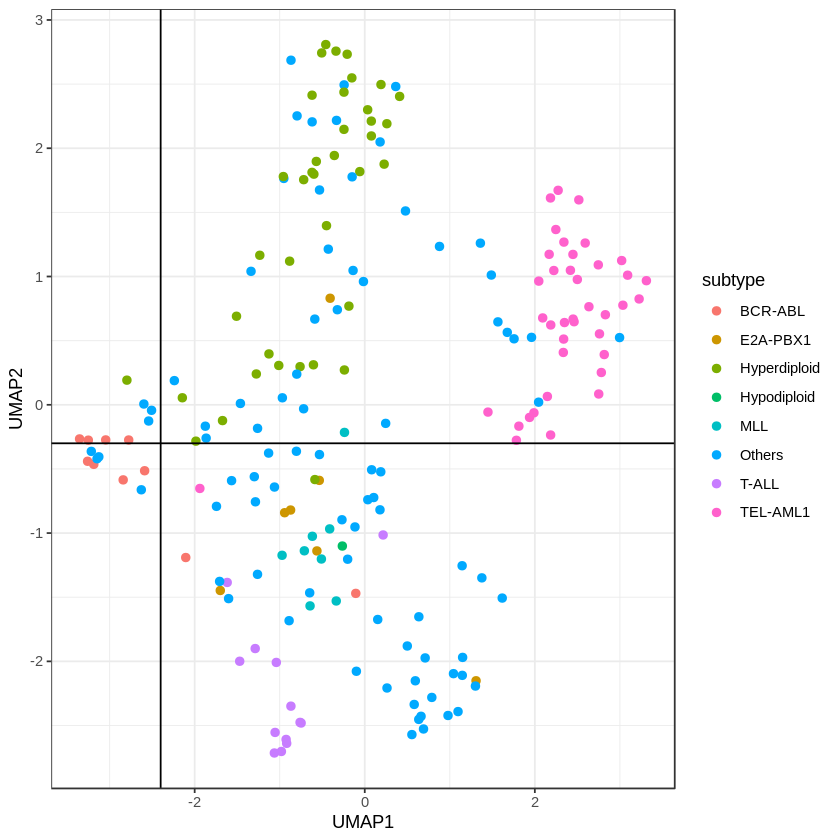

In [464]:
THRESHOLD1 <- -2.4
THRESHOLD2 <- -0.3

ax_umap +
  geom_vline(xintercept = THRESHOLD1) +
  geom_hline(yintercept = THRESHOLD2)

In [465]:
z_umap <- obj$layout
sid <- rownames(z_umap)[z_umap[, 1] < THRESHOLD1 & z_umap[, 2] < THRESHOLD2]
sid_bcrabl_like_d0 <- sid[Y[sid, "subtype"] == "Others"]
sid_bcrabl_like_d8 <- paste0(substring(sid_bcrabl_like_d0, 1, 4), "_D8")
sid_bcrabl_like <- c(sid_bcrabl_like_d0, sid_bcrabl_like_d8)

#### Identify TEL-AML1 outlier
- P023_D0

In [470]:
# Remove batch effect ps
d0_fltr <- data[
  !(rownames(data) %in% batch_ps),
  Y[colnames(data), "class_info"] == "D0"
]

ALPHA <- .01
M <- 50
# Feature selection: For each of the 6 subtypes
all_ps <- data.frame()
for (subtype in subtypes6) {
  idx_subtype <- Y[colnames(d0_fltr), "subtype"] == subtype
  d0_subtype <- d0_fltr[, idx_subtype]
  d0_rest <- d0_fltr[, !idx_subtype]
  row_pvalue <- calc_univariate(wilcox.test, d0_subtype, d0_rest)
  
  idx_num <- which(rank(row_pvalue) <= M)
  sig_ps <- rownames(d0_fltr)[idx_num] # OPTION: Top M
#   sig_ps <- rownames(d0_fltr)[row_pvalue < ALPHA]   # OPTION: pvalue
  
  subtype_ps <- data.frame(probesets = sig_ps, subtype = subtype)
  all_ps <- rbind(all_ps, subtype_ps)
}
all_ps$probesets <- as.character(all_ps$probesets)

In [478]:
d0_fltr1 <- d0_fltr[all_ps$probesets, ]
umap_obj <- umap(t(d0_fltr1))
ax_umap <- plot_umap(umap_obj, Y, col = 'subtype')
ggsave('~/Dropbox/temp/umap-d0_wilcox.pdf', ax_umap, width = 7, height = 4)

In [479]:
z_umap <- umap_obj$layout
sid <- rownames(z_umap)[z_umap[, 1] > -1]
sid_outlier <- sid[Y[sid, 'subtype'] == 'TEL-AML1']
sid_outlier

[1] "P023_D0"

In [ ]:
list_train_test <- lapply(
  list_X_subtypes5,
  predict_pipeline,
  X_normal,
  metadata,
  metadata_pid,
  batch_ps,
  sid_train_test = list(sid_train, sid_test)
)

## Plot: Boxplots

### Evaluate with DUX4 (all train)

In [65]:
X_dux4 <- data[, sid_dux4]
X_normal <- data[, sid_normal]
dux4_pred <- predict_pipeline(
  X_dux4, X_normal,
  annot, yeoh_label,
  batch_ps
)

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 772"
[1] "No. of features (p-value) = 2564"
[1] "No. of features (log2-fc) = 679"
[1] "No. of selected genes = " "660"                     
[1] "No. of final genes = " "480"                  
[1] "NO. OF SAMPLES IN CENTROID: 19"


In [67]:
#' Plots boxplot of features, p_rem WITHOUT global ERM
#' Provides p-values from wilcoxon rank-sum test
plot_boxplots2 <- function(X_y, cex = 2.5) {
  FEAT_ORDER <- c(
    "erm1_ratio2", "l2norm_ratio2", "angle_d0d8_d0normal",
    "log_mrd", "p_wo_mrd", "p_rem"
  )
  FEAT_LABS <- c(
    "'ERM Ratio'", "'ARM Ratio'", "theta",
    "log[10](MRD)", "paste('P(Remission|', bold(x), '*, s)')",
    "paste('P(Remission|', bold(x), ', s)')"
  )
  
  long_X_y <- melt(
    X_y,
    id = c("label", "treatment_type"),
    variable.name = "feature"
  )
  
  # Reorder levels and label features
  long_X_y$feature <- factor(
    long_X_y$feature,
    levels = FEAT_ORDER,
    labels = FEAT_LABS
  )
  levels(long_X_y$label) <- c("Remission", "Relapse")
  
  ax_jitter <- ggplot(
    long_X_y,
    aes(x = label, y = value)
  ) +
    facet_wrap(
      ~feature,
      nrow = 1, scales = "free",
      labeller = label_parsed
    ) +
    geom_boxplot(
      aes(group = label),
      outlier.shape = NA
    ) +
    geom_point(
      aes(fill = label),
      position = position_jitterdodge(
        jitter.width = .8,
        dodge.width = 1.2,
      ),
      cex = cex, pch = 21, alpha = 1,
      col = "black", show.legend = F
    ) +
    scale_fill_manual(values = COL_LABEL) +
    theme(
      axis.title.x = element_blank(),
      axis.text.x = element_text(angle = 15),
      axis.title.y = element_blank(),
      legend.position = "none"
    )
  
  # Jitter plot: p-value label
  # Both group sizes must be > 1
  if (length(table(X_y$label)) > 1 && min(table(X_y$label)) > 1) {
    p_labs <- sapply(
      FEAT_ORDER,
      function(idx) {
        list_feat <- split(X_y[, idx], X_y$label)
        tryCatch(
          {
            htest <- wilcox.test(
              list_feat[[1]], list_feat[[2]], exact = T
            )
            sprintf("p = %.3f", htest$p.value)
          },
          error = function(err) {
            print(err)
            return(err)
          }
        )
      }
    )
    
    ann_text <- data.frame(
      feature = factor(
        FEAT_ORDER,
        levels = FEAT_ORDER,
        labels = FEAT_LABS
      ),
      value = c(
        max(X_y[FEAT_ORDER[1]]),
        max(X_y[FEAT_ORDER[2]]),
        min(X_y[FEAT_ORDER[3]]),        
        min(X_y[FEAT_ORDER[4]]),
        max(X_y[FEAT_ORDER[5]]),
        max(X_y[FEAT_ORDER[6]])
      ),
      label = p_labs
    )
    ann_text <- na.omit(ann_text)

    ax_jitter <- ax_jitter +
      geom_text(
        data = ann_text,
        aes(x = 1.5, y = value, label = label),
        size = 3, # colour = "black",
        hjust = 0
      )
  }
  
  ax_jitter
}

In [70]:
wpath <- "~/Dropbox/tmp/features_alltrain1-dux4.pdf"
ggsave(wpath, plot_boxplots2(dux4_pred$X_y), width = 9, height = 2.5)

Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(list_feat[[1]], list_feat[[2]], exact = T):
“cannot compute exact p-value with ties”Warning message:
“position_jitterdodge requires non-overlapping x intervals”Warning message:
“position_jitterdodge requires non-overlapping x intervals”Warning message:
“position_jitterdodge requires non-overlapping x intervals”Warning message:
“position_jitterdodge requires non-overlapping x intervals”Warning message:
“position_jitterdodge requires non-overlapping x intervals”Warning message:
“position_jitterdodge requires non-overlapping x intervals”

In [103]:
#' Predict each subtype with train/test split
#' ASSUME: sid_train and sid_test contain no patients with NA MRD values
#' @param subtype string indicating subtype
predict_pipeline_test <- function(
  sid_subtype, X_normal,
  metadata, metadata_mrd,
  sid_train, sid_test,
  batch_genes,
  sid_remission, sid_normal, X
) {  
  sid_subtype_train <- intersect(sid_subtype, sid_train)
  sid_subtype_test <- intersect(sid_subtype, sid_test)
  
  subtype_train <- X[, sid_train, drop = F]
  subtype_test <- X[, sid_test, drop = F]
  
  ## Feature selection using train set
  class_genes <- getLocalGenes(subtype_train, sid_remission)
  selected_genes <- setdiff(class_genes, batch_genes)
  
  print(c("No. of class genes = ", length(class_genes)))
  print(c("No. of selected genes = ", length(selected_genes)))
  
  # Subtype and normal samples
  response <- t(X[selected_genes, sid_subtype, drop = F])
  normal <- t(X[selected_genes, sid_normal, drop = F])
  
  # Compute features on both train and test
  V <- compute_features(response, normal, sid_train, sid_remission)
  V$mrd <- metadata_mrd[rownames(V), "d33_mrd"] # append column
  
  print(sid_subtype_train)
  print(sid_subtype_test)
  if (!(is_paired(sid_subtype_train)))
    stop("sample ids are not paired")
  if (!(is_paired(sid_subtype_test)))
    stop("sample ids are not paired")
  
  pid_subtype_train <- unique(substring(sid_subtype_train, 1, 4))
  pid_subtype_test <- unique(substring(sid_subtype_test, 1, 4))
  
  V_train <- V[pid_subtype_train, , drop = F ]
  V_test <- V[pid_subtype_test, , drop = F ]
  
  obj_train <- predict_plot(
    V_train, metadata,                             
    bigpos_names = "angle_d0d8_d0normal",
    smallpos_names = c("erm1_ratio2", "l2norm_ratio2", "mrd")
  )
  
  obj_test <- predict_plot(
    V_train, metadata,                             
    bigpos_names = "angle_d0d8_d0normal",
    smallpos_names = c("erm1_ratio2", "l2norm_ratio2", "mrd"),
    V_test
  )
  
  list(train = obj_train, test = obj_test)
}

#### Train: TEL-AML1, Test: TEL-AML1-like

In [145]:
# Remove P095 which has NA MRD value
sid_telaml1_like_d0 <- setdiff(sid_telaml1_like_d0, 'P095_D0')

sid_telaml1_like_d8 <- sub("D0", "D8", sid_telaml1_like_d0)
sid_telaml1_like <- c(sid_telaml1_like_d0, sid_telaml1_like_d8)

sid_telaml1 <- sid_alltrain_local[
  annot[sid_alltrain_local, "subtype"] == "TEL-AML1"]
sid_all <- c(sid_telaml1, sid_telaml1_like)
sid_all <- sort_sid(sid_all)

In [146]:
X_normal <- data[, sid_normal]
telaml1_like_test <- predict_pipeline_test(
  sid_all,
  X_normal, annot, yeoh_label,
  sid_telaml1, sid_telaml1_like,
  batch_ps,
  sid_remission, sid_normal, data
)

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 710"
[1] "No. of features (p-value) = 2765"
[1] "No. of features (log2-fc) = 507"
[1] "No. of class genes = " "505"                  
[1] "No. of selected genes = " "371"                     
 [1] "P013_D0" "P014_D0" "P015_D0" "P016_D0" "P017_D0" "P018_D0" "P019_D0"
 [8] "P022_D0" "P023_D0" "P024_D0" "P025_D0" "P026_D0" "P027_D0" "P028_D0"
[15] "P029_D0" "P031_D0" "P032_D0" "P033_D0" "P034_D0" "P035_D0" "P036_D0"
[22] "P094_D0" "P099_D0" "P106_D0" "P120_D0" "P121_D0" "P126_D0" "P127_D0"
[29] "P130_D0" "P135_D0" "P136_D0" "P147_D0" "P150_D0" "P156_D0" "P165_D0"
[36] "P166_D0" "P171_D0" "P172_D0" "P187_D0" "P191_D0" "P197_D0" "P199_D0"
[43] "P210_D0" "P213_D0" "P216_D0"
[1] "NO. OF SAMPLES IN CENTROID: 29"
 [1] "P013_D0" "P014_D0" "P015_D0" "P016_D0" "P017_D0" "P018_D0" "P019_D0"
 [8] "P022_D0" "P023_D0" "P024_D0" "P025_D0" "P026_D0" "P027_D0" "P028_D0"
[15] "P029_D0" "P031_D0" "P032_D0" "P033_D0" "P

In [149]:
ax <- telaml1_like_test$test$plot
wpath <- '~/Dropbox/tmp/features_test-telaml1_like.pdf'
ggsave(wpath, ax, width = 8, height = 2.5)

#### All train: TEL-AML1 & TEL-AML-like

In [150]:
all_telaml1 <- data[, sid_all]
X_normal <- data[, sid_normal]
all_telaml1 <- predict_pipeline(
  all_telaml1, X_normal,
  annot, yeoh_label,
  batch_ps
)

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 733"
[1] "No. of features (p-value) = 2663"
[1] "No. of features (log2-fc) = 458"
[1] "No. of selected genes = " "458"                     
[1] "No. of final genes = " "349"                  
 [1] "P013_D0" "P014_D0" "P015_D0" "P016_D0" "P017_D0" "P018_D0" "P019_D0"
 [8] "P022_D0" "P023_D0" "P024_D0" "P025_D0" "P026_D0" "P027_D0" "P028_D0"
[15] "P029_D0" "P031_D0" "P032_D0" "P033_D0" "P034_D0" "P035_D0" "P036_D0"
[22] "P094_D0" "P099_D0" "P106_D0" "P120_D0" "P121_D0" "P126_D0" "P127_D0"
[29] "P130_D0" "P135_D0" "P136_D0" "P147_D0" "P150_D0" "P156_D0" "P165_D0"
[36] "P166_D0" "P171_D0" "P172_D0" "P187_D0" "P191_D0" "P197_D0" "P199_D0"
[43] "P210_D0" "P213_D0" "P216_D0"
[1] "NO. OF SAMPLES IN CENTROID: 39"


In [153]:
ax <- all_telaml1$plot
wpath <- "~/Dropbox/tmp/features_alltrain-telaml1.pdf"
ggsave(wpath, ax, width = 8, height = 2.5)

#### Train: BCR-ABL, Test: BCR-ABL-like

In [466]:
# Plot UMAP of BCR-ABL and BCR-ABL-like
idx_bcrabl <- Y[colnames(data), "subtype"] == "BCR-ABL" &
  colnames(data) %in% sid_alltrain

sid_bcrabl <- colnames(data)[idx_bcrabl]
sid_all <- sort_sid(c(sid_bcrabl, sid_bcrabl_like))
print(sid_all)

# all_bcrabl_hvg300 <- select_hvg(data[, sid_all], 300)

# umap_obj <- umap(t(all_bcrabl_hvg300))
# plot_umap(umap_obj, Y, col = 'subtype')

 [1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P075_D0" "P097_D0"
 [8] "P134_D0" "P152_D0" "P170_D0" "P175_D0" "P184_D0" "P200_D0" "P202_D0"
[15] "P053_D8" "P054_D8" "P055_D8" "P056_D8" "P057_D8" "P075_D8" "P097_D8"
[22] "P134_D8" "P152_D8" "P170_D8" "P175_D8" "P184_D8" "P200_D8" "P202_D8"


In [467]:
X_normal <- data[, sid_normal]
prediction <- predict_pipeline_test(
  sid_all,
  X_normal, Y, yeoh_label,
  sid_bcrabl, sid_bcrabl_like,
  batch_ps,
  sid_remission, sid_normal, data
)

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 725"
[1] "No. of features (p-value) = 170"
[1] "No. of features (log2-fc) = 214"
[1] "No. of class genes = " "21"                   
[1] "No. of selected genes = " "14"                      
 [1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P075_D0" "P097_D0"
 [8] "P134_D0" "P152_D0" "P170_D0" "P175_D0" "P184_D0" "P200_D0" "P202_D0"
[1] "NO. OF SAMPLES IN CENTROID: 5"
 [1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P134_D0" "P152_D0"
 [8] "P170_D0" "P175_D0" "P184_D0" "P053_D8" "P054_D8" "P055_D8" "P056_D8"
[15] "P057_D8" "P134_D8" "P152_D8" "P170_D8" "P175_D8" "P184_D8"
[1] "P075_D0" "P097_D0" "P200_D0" "P202_D0" "P075_D8" "P097_D8" "P200_D8"
[8] "P202_D8"


In [468]:
feat_bcrabl <- prediction$train$plot
wpath <- "~/Dropbox/temp/features-heg_bcrabl.pdf"
ggsave(wpath, feat_bcrabl, width = 8, height = 2.5)

In [469]:
feat_bcrabl_like <- prediction$test$plot
wpath <- "~/Dropbox/temp/features-heg_bcrabl_like.pdf"
ggsave(wpath, feat_bcrabl_like, width = 8, height = 2.5)

In [290]:
#' Does not perform PCA transform on data
#' Used to predict relapse for all subtypes
#' X df containing all subtypes of patients in arg: pid and normal patients
#' @param pid vector of pid belonging to both D0 and D8 patients (identically ordered)
#' @return list containing prediction plot and vector coordinates
predict_pipeline1 <- function(X_subtype, X_normal,
                             metadata, metadata_mrd,
                             batch_genes = NULL) {
  sid_remission <- colnames(X_subtype)[
    metadata[colnames(X_subtype), "label"] == 0
  ]
  
  class_genes <- getLocalGenes(X_subtype, sid_remission)
  
  if (is.null(batch_genes)) {
    selected_genes <- class_genes
  } else {
    selected_genes <- setdiff(class_genes, batch_genes)
  }
  
  print(c("No. of selected genes = ", length(class_genes)))
  print(c("No. of final genes = ", length(selected_genes)))
  
  # Subtype and normal samples
  response <- t(X_subtype[selected_genes, ])
  normal <- t(X_normal[selected_genes, ])
  
  # Collate MRD results as well
  V <- compute_features(response, normal, colnames(X_subtype), sid_remission)
  V$mrd <- metadata_mrd[rownames(V), "d33_mrd"]
  V <- cbind(V, delta_cd[rownames(V), "mean", drop = F])
  
  prediction_obj <- predict_plot1(
    V, metadata,                             
    bigpos_names = "angle_d0d8_d0normal",
    smallpos_names = c("erm1_ratio2", "l2norm_ratio2", "mrd", "mean")
  )
  
  return(prediction_obj)
}

# Important genes

## Plot: Heatmap

In [16]:
# NAME_GPL570 <- "../info/microarray/HG-U133_Plus_2/annot_genesymbol-GPL570.tsv"
# a_yeoh <- affy2id(yeoh_allps, NAME_GPL570)
# gene_mapping <- affy2id(yeoh_allps, NAME_GPL570, ret.annot = T)

No. of probesets with no ID removed: 1052
Total no. of probesets removed (incl. probesets mapping to same gene): 8762
No. of probesets with no ID removed: 1052
Total no. of probesets removed (incl. probesets mapping to same gene): 8762


In [45]:
# # Selecting CD marker genes
# grep_genes <- grep('^CD[0-9]', rownames(a_yeoh), value = T)
# wrong_genes <- c('CD2BP2', 'CD2AP', 'CD3EAP', 'CD5L', 'CD40LG')
# cd_genes <- setdiff(grep_genes, wrong_genes)

# yeoh_cd <- a_yeoh[cd_genes, ]
# # all_cd <- ann_yeoh2[cd_genes, ] # Includes D33 samples

# # Rename genes with multiple names
# rename_genes <- c('CD8B', 'CD68', 'CD302')
# for (gene in rename_genes) {
#   rownames(yeoh_cd)[grep(gene, rownames(yeoh_cd))] <- gene
# }
# # for (gene in rename_genes) {
# #   rownames(all_cd)[grep(gene, rownames(all_cd))] <- gene
# # }

In [385]:
# ambi_ps <- all_ps[grepl("///", all_ps)]
# ambi_ps1 <- sapply(ambi_ps, sub, pattern = " ///.*", replacement = "")
# all_ps[grepl("//", all_ps)] <- ambi_ps1

[1] 183

[1] 280

No. of probesets with no ID removed: 819
Total no. of probesets removed (incl. probesets mapping to same gene): 2559


#### Feature selection might lead to overfitting
- Selecting highly D.E. features in remission samples
- If the D.E. features in relapse samples are independent, then highly unlikely that shift in relapse > remission

#### Heterogeneity
- Heterogeneity in the starting and ending point?
- Heterogeneity in response

#### Easy solutions
- No feature selection. Plot angle of optimal v.s. own response
- Use optimal as vector to project on

#### Assumption of states
- Assuming that it has to progress towards an end state
- Maybe it has to go to an intermediate state first
- If the state is the proportion of cells, then the above does not hold. i.e. Should progress towards normal patients
- Methotrexate: Antimetabolite
- Prednisolone: Steroid
- Vincristine: Inhibit cell division
- Dexamethasone: Counteract side effects
- Daunorubicin: Anthracycline (interfere with DNA metabolism and RNA production)

- Initial hypothesis:
    - Higher proportion of cancer cells to lower proportion
- New hypothesis:
    - Leukemia state: 100% blasts
        - Restricted to earlier states in developmental trajectory
        - Slight perturbation
    - Normal state: 100% normal WBCs
        - Full range in developmental traj
    - Response state: x% normal, (1-x)% blasts
        - All WBCs at later stage can be attributed to normal cells?
        - Assume that normal cells have the same distribution along developmental traj
        - Work out no. of normal cells from the no. of later stage cells
        - Total - later stage - normal early = No. of blasts
- Extension to bulk data
   - Find genes that are indicative of late stage normal cells?
   - Use ratios of gene expression to find out number of normal cells?
   - Gene expression that exceed that number will represent the blasts??

#### Batch effects
- Presence of batch effects?
- Delete the batch effects genes

#### Filtering and Aggregation
- Filtering out batch effect genes
- Aggregating by pathway info

- Proportion of B-cells are much greater than non B-cells in scRNA-Seq data
- Perturbed B-cells, monocytes are important

### Plot: Vectors (UMAP)

In [152]:
# umap_others <- umap(t(others_normal))

In [129]:
# umap_others1 <- cbind(
#   x = umap_others$layout,
#   Y[rownames(umap_others$layout), ]
# )

# umap_others2 <- umap_others1[umap_others1$subtype == "Others", ]
# umap_normal <- umap_others1[umap_others1$subtype == "Normal", ]
# umap_others3 <- umap_others2[seq_len(nrow(umap_others2) / 2), ]
# others_d8 <- umap_others2[seq(nrow(umap_others2) / 2 + 1, nrow(umap_others2)), 1:2]
# umap_others4 <- cbind(umap_others3, others_d8)
# umap_others4 <- umap_others4[, c(1,2,7,8,3:6)]
# colnames(umap_others4)[1:4] <- c("start_x", "start_y", "end_x", "end_y")
# umap_others4$batch_info <- as.factor(umap_others4$batch_info)
# umap_others4$label <- as.factor(umap_others4$label)
# arrow_col <- ifelse(umap_others4$label == 0, "black", "red")

# scatter_pca <- ggplot(data = umap_others4) +
#   geom_point(aes(x = start_x, y = start_y, colour = batch_info),
#              shape = 15, size = cex, show.legend = T) +
#   geom_point(aes(x = end_x, y = end_y, colour = batch_info),
#              shape = 16, size = cex, show.legend = F) +
#   geom_segment(
#     aes(x = start_x, y = start_y, xend = end_x, yend = end_y),
#     arrow = arrow(length = unit(0.3, "cm")),
#     alpha = 0.5,
#     color = arrow_col
#   ) +
#   geom_point(data = umap_normal, aes(x = x.1, y = x.2),
#              size = cex, shape = 17)

# ggsave("~/Dropbox/temp/umap-others.pdf", scatter_pca)

Saving 6.67 x 6.67 in image


## Plot: Vectors (PCA)

In [139]:
# pca_all <- plot_vectors(others, Y)
# ggsave("~/Dropbox/temp/vectors-pca_all.pdf", pca_all)

# others_fltr <- others[!(rownames(others) %in% batch_genes), ]
# pca_wo_batch <- plot_vectors(others_fltr, Y)
# ggsave("~/Dropbox/temp/vectors-pca_wo_batch.pdf")

 [1] 1 1 1 2 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 2 2 2 2 1 2 2
[39] 1 2 1 1 1 1 2 2 1 1 1 2 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 2 1 2 1 1 1 2 1 1
[77] 1 1 2 1 1 1 1 2 1


Saving 6.67 x 6.67 in image


## B cell marker genes
- Normal GEPs are localised with D0 and D8 GEPs
- D33 GEPs seem to suffer from batch effects

In [16]:
NAME_GPL570 <- "../info/microarray/HG-U133_Plus_2/annot_genesymbol-GPL570.tsv"
ann_allps <- affy2id(yeoh_allps, NAME_GPL570)

d33_allps <- affy2id(yeoh_d33, NAME_GPL570)

No. of probesets with no ID removed = 1052
Total no. of probesets removed (incl. probesets mapping to same gene): 8762


In [17]:
# Finalised list of B-cell CD markers (strictly B-cell)
strict_bcell <- c('CD19', 'CD38', 'CD72', 'CD79A', 'CD79B')

In [70]:
adata0_allps <- cbind(ann_allps, d33_allps)
metadata_all <- annot_all[colnames(adata0_allps), ]

In [122]:
others_normal_b <- ann_allps[strict_bcell, metadata$subtype %in% c("Others", "Normal")]

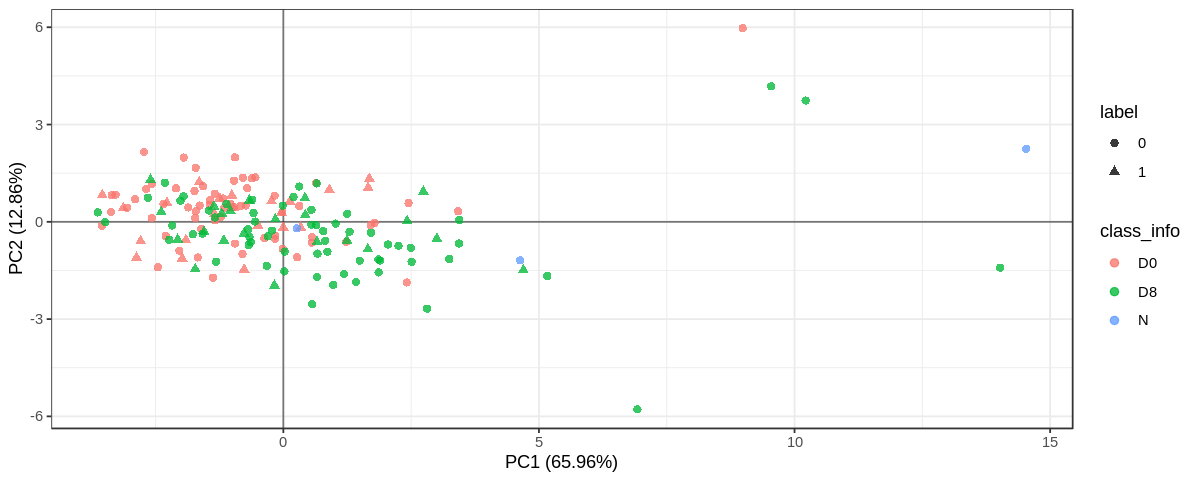

In [125]:
options(repr.plot.width = 10, repr.plot.height = 4)
ax1 <- ggplot_pca(others_normal_b, metadata_all, shape = 'label', color = 'class_info')
ax1